In [39]:
import mesa
import numpy as np
import mesa
import random
import math
import modules as modules
import model as model
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

In [ ]:
def compute_entropy(model: mesa.Model, loc: tuple, agent_type):
    similar = 0
    num_neighbors = 0

    for neighbor in model.grid.iter_neighbors(loc, moore=True, radius=model.radius):
        num_neighbors += 1
        if neighbor.type == agent_type:
            similar += 1

    if num_neighbors == 0:
        return 0  # No neighbors means zero entropy

    proportion_similar = similar / num_neighbors
    proportion_different = 1 - proportion_similar

    if proportion_similar == 0 or proportion_different == 0:
        return 0  # If all neighbors are similar or all are different, entropy is zero

    entropy = - (proportion_similar * math.log2(proportion_similar) + proportion_different * math.log2(proportion_different))
    return entropy

# Added Modules

In [ ]:
def utility_func(model: mesa.Model, agent: mesa.Agent, agent_loc: tuple, property_loc: tuple) -> float:
    
    theta = model.get_theta(agent_loc, model.grid.get_property(property_loc))

    desirability = model.desirability_layer(property_loc)

    alpha = model.alpha

    budget = agent.budget
    
    price = model.price_func(property_loc)
    
    return theta**alpha*desirability**(1-alpha)*((budget-price)/budget)

In [20]:
def calculate_gi_star(grid, values, x, y, d):
    sum_wx = 0
    sum_w = 0
    sum_wx2 = 0
    n = len(values)

    for (i, j), value in values.items():
        dist = np.sqrt((x - i)**2 + (y - j)**2)
        if dist <= d:
            w = 1  # Binary weight, 1 if within distance threshold
            sum_wx += w * value
            sum_w += w
            sum_wx2 += w * value**2

    mean_x = np.mean(list(values.values()))
    s = np.std(list(values.values()))

    numerator = sum_wx - mean_x * sum_w
    denominator = s * np.sqrt((n * sum_w - sum_w**2) / (n - 1))

    return numerator / denominator if denominator != 0 else 0

In [26]:
NO_NEIGHBORS_THETA = 0.5

class SchellingAgent(mesa.Agent):
    """
    Schelling segregation agent
    """

    def __init__(self, unique_id, model, agent_type, budget):
        """
        Create a new Schelling agent.

        Args:
           unique_id: Unique identifier for the agent.
           agent_type: Indicator for the agent's type (minority=1, majority=0)
           budget: Budget for the agent
        """
        super().__init__(unique_id, model)
        self.type = agent_type
        self.budget = budget
        self.utility = 0.5
        self.segregation = None
        self.move_counter = 0

    def calc_theta(self):
        # Calculate theta using the model's get_theta method
        self.segregation = modules.get_theta(self.model, self.pos, self.type)

    def step(self):
        """
        Step for agent to move
        In a step an agent will:
            1. Find available properties to move to
            2. Calculate their utility for each property
            3. If the property with the highest utility has a higher utility than the current property, move there
            4. Update the utility of the agent in their new location
        """
        # update utility
        self.utility = self.model.utility_func(self.model, self, self.pos)
        
        self.calc_theta()

        # find the available properties to move to
        available_cells = self.model.find_available_cells(self)
                
        if len(available_cells) < 0:
            return
        
        # list all utilities of available properties
        move_util = []
        for cell in available_cells:
            # store as (cell, utility) tuple
            move_util.append((cell, self.model.utility_func(self.model, self, cell)))
        
        # sort by utility
        move_util.sort(key=lambda x: x[1], reverse=True)
        
        # move if utility is higher than current
        if move_util[0][1] > self.utility:
            self.model.grid.move_agent(self, move_util[0][0])
            # update utility
            self.utility = move_util[0][1]
            self.move_counter += 1


class Schelling(mesa.Model):
    """
    Model class for the Schelling segregation model.
    """

    def __init__(
        self,
        property_value_func,
        income_func,
        desirability_func,
        utility_func,
        price_func,
        compute_similar_neighbours,
        ##########
        calculate_gi_star,
        ##########
        height=20,
        width=20,
        homophily=0.5,
        radius=1,
        density=0.8,
        minority_pc=0.2,
        alpha=0.5,
        income_scale=1.5, # the scale by which the income is higher than the property value
        property_value_weight=0.1,
        mu_theta = 0.8,
        sigma_theta = 0.1,
        entropy = -1, # initialize entropy for a non-possible value
        seed=None
    ):
        """
        Create a new Schelling model.

        Args:
            width, height: Size of the space.
            density: Initial chance for a cell to be populated
            minority_pc: Chance for an agent to be in minority class
            homophily: Minimum number of agents of the same class needed to be happy
            radius: Search radius for checking similarity
            seed: Seed for reproducibility
            property_value: Value for the property
        """

        super().__init__(seed=seed)
        self.utility_func = utility_func
        self.price_func = price_func
        self.desirability_func = desirability_func
        self.prop_value_weight = property_value_weight
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily
        self.radius = radius
        self.alpha = alpha
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta
        self.entropy = entropy
        
        #############
        self.compute_similar_neighbours = compute_similar_neighbours
        self.neighbor_similarity_counter = {}
        self.calculate_gi_star = calculate_gi_star
        self.gi_star_history = []
        #############

        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)

        # Property Value Layer
        self.property_value_layer = property_value_func(name="property_values", width=width, height=height)
        self.grid.add_property_layer(self.property_value_layer)

        # Desirability Layer
        self.desirability_layer = mesa.space.PropertyLayer("desirability", width, height, 0.5)
        # for _, pos in self.grid.coord_iter():
        #     self.desirability_layer[pos] = 1
        self.grid.add_property_layer(self.desirability_layer)
        
        # Interested Agents Counter Layer
        self.interested_agents_layer = mesa.space.PropertyLayer("interested_agents", width, height, 0)
        # for _, pos in self.grid.coord_iter():
        #     self.interested_agents_layer[pos] = 0
        self.grid.add_property_layer(self.interested_agents_layer)
        
        # Utility Layer
        self.utility_layer = mesa.space.PropertyLayer("utility", width, height, 0.5) 
        self.grid.add_property_layer(self.utility_layer)

        #Data Collectors
        self.datacollector = mesa.DataCollector(
            agent_reporters={"Utility": "utility", "Segregation":"segregation", "Moves":"move_counter"}, model_reporters={"Desirability": self.desirability_layer.data.tolist}  # Collect the utility of each agent
        )

        # Set up agents
        for _, pos in self.grid.coord_iter():
            if self.random.random() < self.density:
                agent_type = 1 if self.random.random() < self.minority_pc else 0
                budget = income_func(scale=income_scale)
                agent = SchellingAgent(self.next_id(), self, agent_type, budget)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)

        self.datacollector.collect(self)

    def find_available_cells(self, agent):
        available_cells = []
        for _, pos in self.grid.coord_iter():
            if self.grid.is_cell_empty(pos):
                available_cells.append(pos)        
        return available_cells
    ########
    def calculate_hotspots(self, distance_threshold):
            desirability = self.desirability_layer.data
            values = {(i, j): desirability[i][j] for i in range(self.width) for j in range(self.height)}
            gi_star_values = np.zeros((self.width, self.height))

            for x in range(self.width):
                for y in range(self.height):
                    gi_star_values[x, y] = calculate_gi_star(self.grid, values, x, y, distance_threshold)

            return gi_star_values
    ########

    def step(self):
        """
        Run one step of the model.
        """
        # Set the count of agents who like to move somewhere to 0 for all cells
        self.interested_agents_layer.set_cells(0)

        ########
        self.neighbor_similarity_counter.clear()
        ########

        for agent in self.schedule.agents:
            # Iterate over cells and compare utility to current location, add to interested_agents_layer if better
            for _, loc  in self.grid.coord_iter():
                utility = self.utility_func(self, agent, loc)
                
                if utility > agent.utility:
                    self.interested_agents_layer.modify_cell(loc, lambda v: v + 1)

            # Compute number of agents with the same number of similar neighbours 
            similar_neighbors = self.compute_similar_neighbours(self, agent)
            if similar_neighbors not in self.neighbor_similarity_counter:
                self.neighbor_similarity_counter[similar_neighbors] = 0
            self.neighbor_similarity_counter[similar_neighbors] += 1

        # Compute total number of agents included
        total_agents = sum(self.neighbor_similarity_counter.values())

        # Compute entropy and store it 
        current_entopy = 0
        for _, p in self.neighbor_similarity_counter.items():
            if p > 0:  # To avoid domain error for log(0)
                probability = p / total_agents
                value = probability * np.log10(probability)
                current_entopy += value
        self.entropy = -current_entopy
    

        # Set desirability layer to the proportion of interested agents
        num_agents = len(self.schedule.agents)
        self.desirability_layer.set_cells(
            self.desirability_func(self, prop_value_weight=self.prop_value_weight)
        )
        ###### ADDED #############
        if self.schedule.steps % 10 == 0:
            distance_threshold = 3
            gi_star_values = self.calculate_hotspots(distance_threshold)
            self.gi_star_history.append((self.schedule.steps, gi_star_values))
        # Calculate hotspots after each step
        #distance_threshold = 3  # Adjust this value as needed
        #gi_star_values = self.calculate_hotspots(distance_threshold)
        #print("Gi* values: ", gi_star_values)
        #############################
    
        self.schedule.step()
        self.datacollector.collect(self)

/var/folders/y2/4b7d_vjj5d70m77w1bxwqw640000gn/T/ipykernel_62433/4005127480.py:139: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  self.desirability_layer = mesa.space.PropertyLayer("desirability", width, height, 0.5)
/var/folders/y2/4b7d_vjj5d70m77w1bxwqw640000gn/T/ipykernel_62433/4005127480.py:145: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  self.interested_agents_layer = mesa.space.PropertyLayer("interested_agents", width, height, 0)
/var/folders/y2/4b7d_vjj5d70m77w1bxwqw640000gn/T/ipykernel_62433/4005127480.py:151: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  self.utility_layer = mesa.space.PropertyLayer("utility", width, height, 0.5)


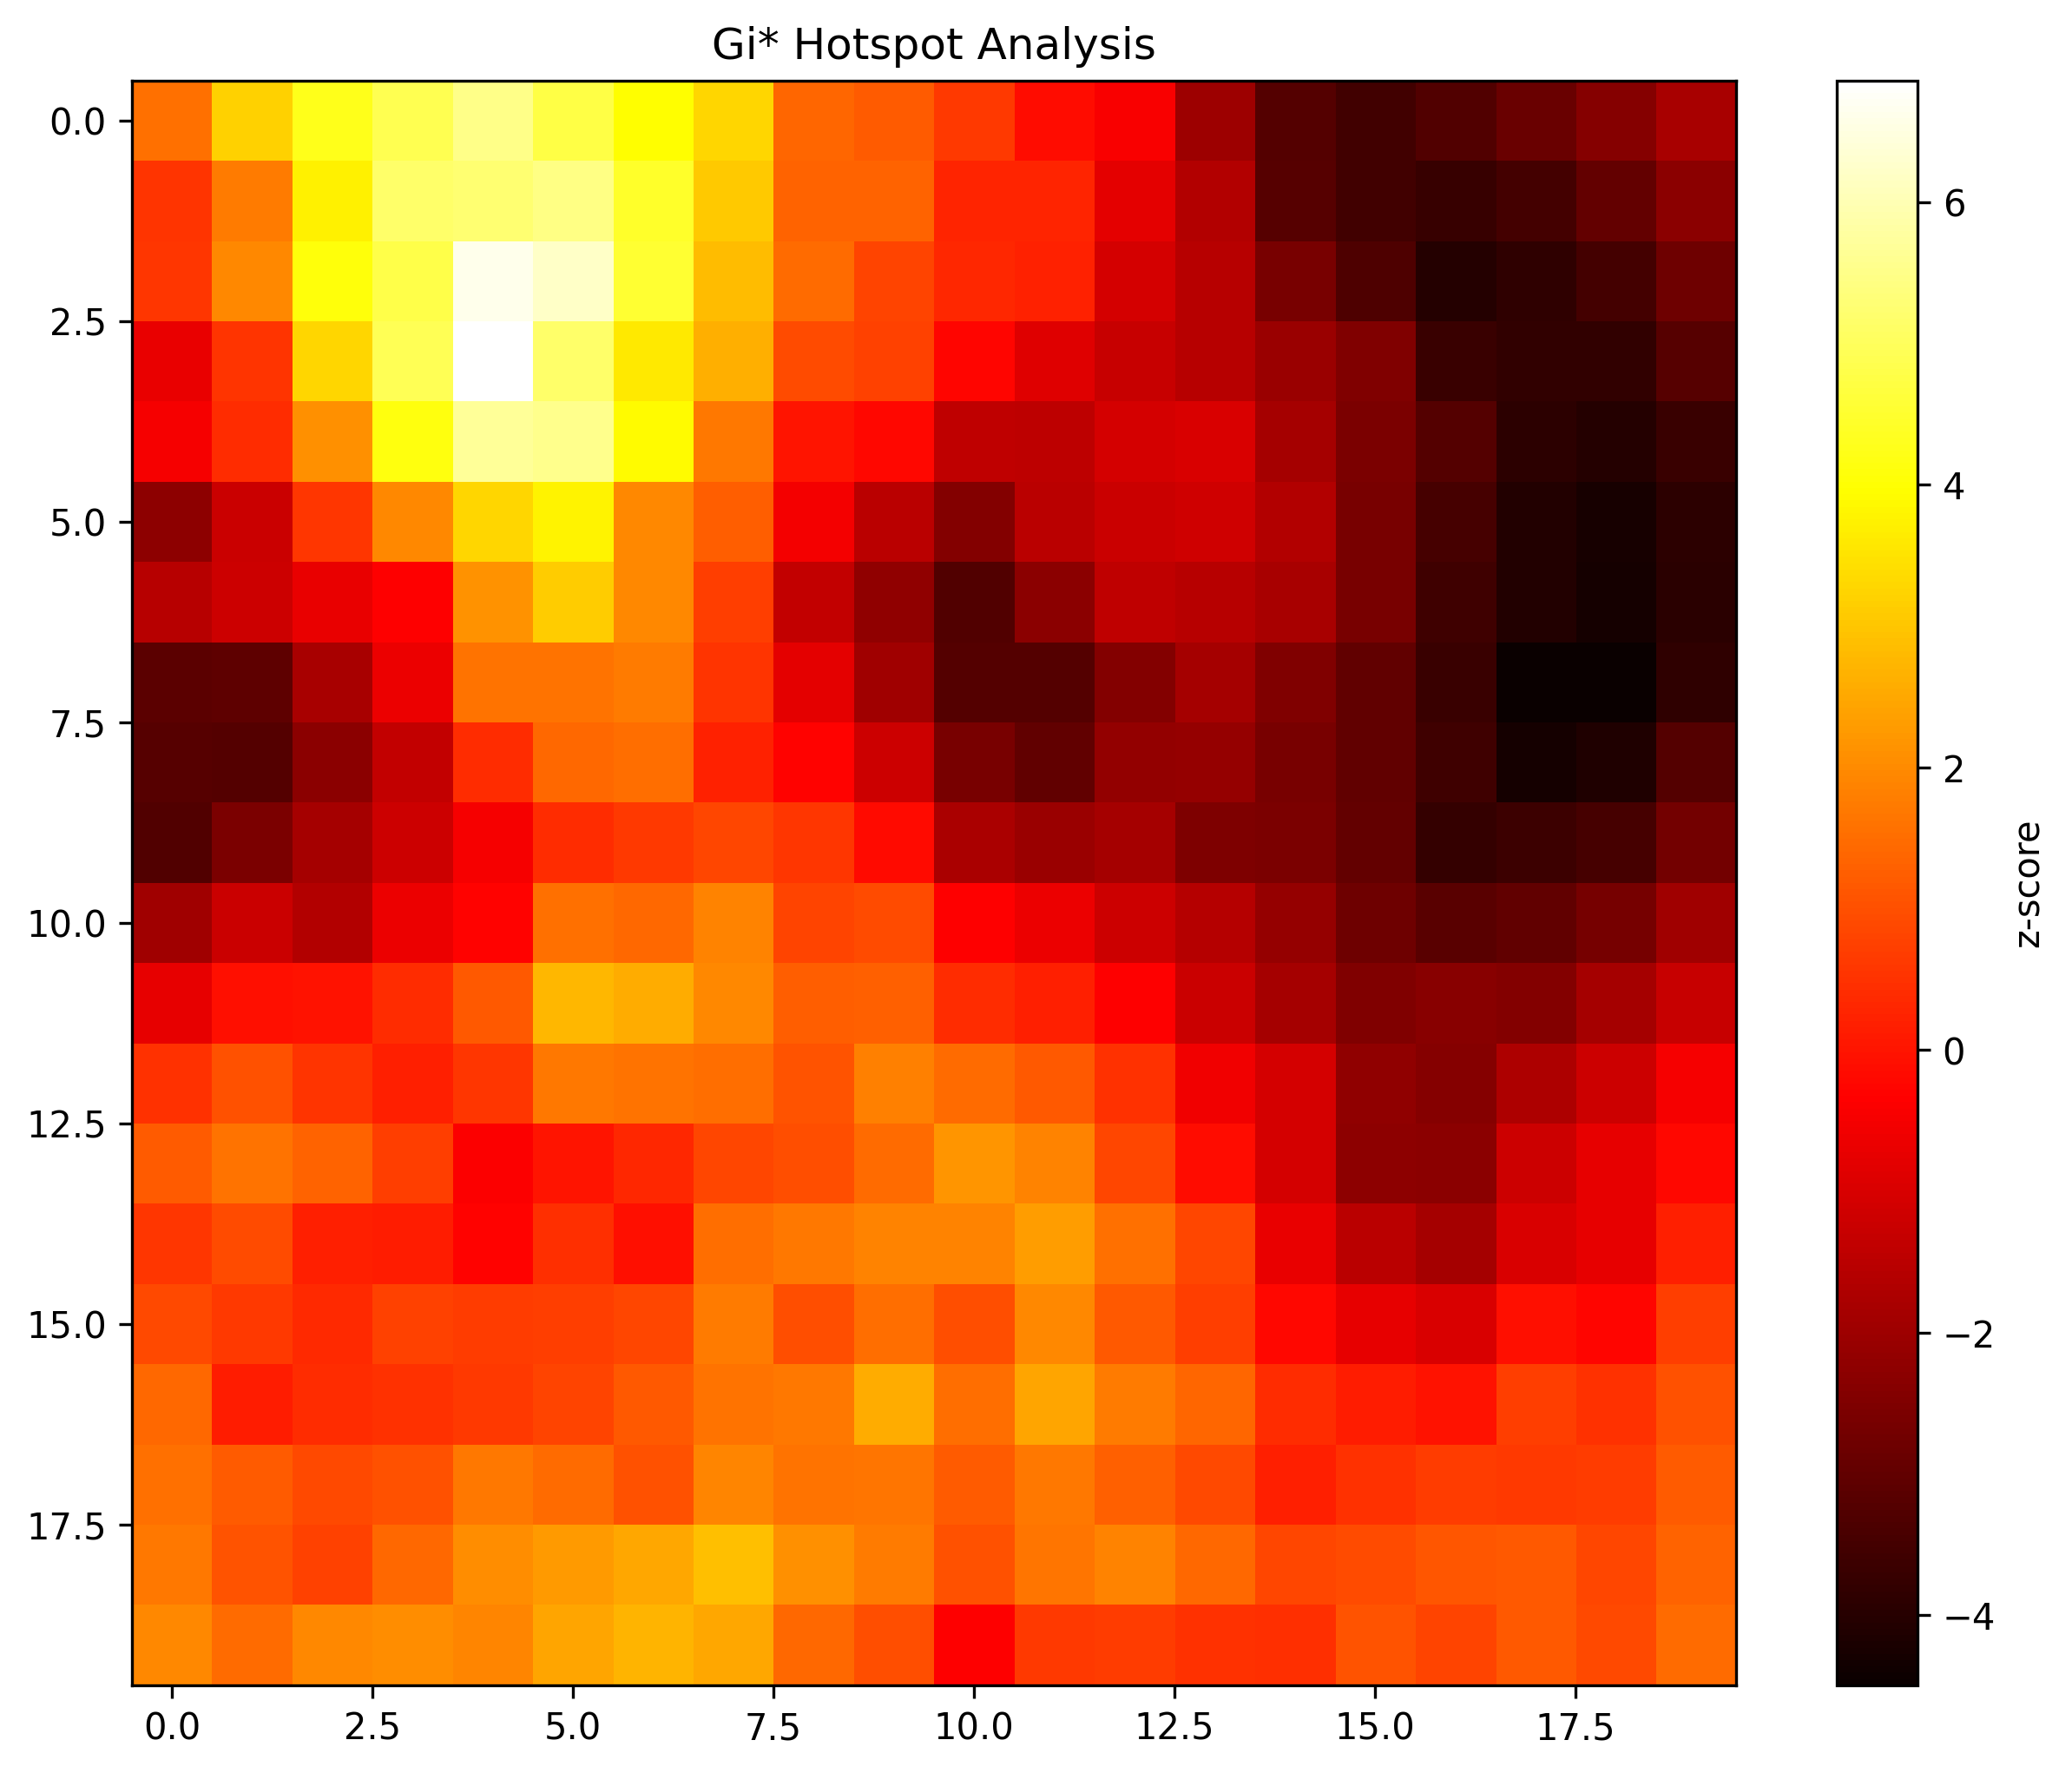

In [33]:
import matplotlib.pyplot as plt

def plot_heatmap(data, title="Heatmap"):
    plt.figure(figsize=(10, 8), dpi=300)
    plt.imshow(data, cmap='hot', interpolation='nearest')
    #plt.colorbar()
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('z-score')
    plt.show()

# Example of usage after a model run
model = Schelling(
     property_value_func=modules.property_value_quadrants,
     income_func=modules.income_func,
     desirability_func=modules.desirability_func,
     utility_func=modules.utility_func,
     price_func=modules.price_func,
     compute_similar_neighbours=modules.compute_similar_neighbours,
        calculate_gi_star=calculate_gi_star,
     height=20,
     width=20,
     #homophily=0.5,
     radius=1,
     density=0.8,
     minority_pc=0.2,
     alpha=0.5,
     seed=42
 )

for i in range(5):
    model.step()
    gi_star_values = model.calculate_hotspots(distance_threshold=3)


plot_heatmap(gi_star_values, title="Gi* Hotspot Analysis")


In [28]:
model.gi_star_history

[(0,
  array([[ 0.81444369,  1.61646701,  1.70541662,  1.92305076,  3.0511442 ,
           2.48709748,  1.92305076,  3.02878655,  1.88432096,  1.81724799,
           1.87991984,  1.81284687,  2.30982062,  1.77411707,  0.74742528,
           0.23407939, -0.2792665 , -0.00727446,  0.33404525, -0.54170903],
         [-0.29227222,  0.23091059,  0.65554426,  2.38349399,  1.37892812,
           2.38349399,  1.88121105,  2.36358452,  1.36967884,  1.33519   ,
           0.82365779,  1.79373481,  0.84497816,  0.8250687 ,  0.36793479,
           0.36793479,  0.8250687 ,  0.1564192 ,  0.23407939, -0.82406619],
         [-0.61314775, -0.37023938,  0.2861981 ,  1.41208554,  1.87036725,
           2.32864897,  2.32864897,  1.43511405,  1.42667503,  0.54286644,
           0.93334993,  0.50782305,  0.49938403,  0.06413083,  0.48121869,
           0.48121869,  0.48121869, -0.13404612,  0.62320839, -0.00727446],
         [-2.0252763 , -1.13248654, -0.87932303, -0.20361232,  1.60005756,
           0.6982

In [14]:
# OFAT
# # Create and run the model
model = model.Schelling(
     property_value_func=modules.property_value_quadrants,
     income_func=modules.income_func,
     desirability_func=modules.desirability_func,
     utility_func=modules.utility_func,
     price_func=modules.price_func,
     compute_similar_neighbours=modules.compute_similar_neighbours,
     height=20,
     width=20,
     #homophily=0.5,
     radius=1,
     density=0.8,
     minority_pc=0.2,
     alpha=0.5,
     seed=42
 )

# # Run the model for a certain number of steps
#for i in range(5):
 #    print(i)
  #   print(model.entropy)
     #print(model.neighbor_similarity_counter)
   #  model.step()

/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Housing/modules.py:23: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Housing/modules.py:23: FutureWarning: The new PropertyLayer and _PropertyGrid classes experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1932
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/carokluin/Documents/CSM/Agent-Based-modelling/ABM_assignment.py/Mesa Schelling Housing/model.py:140: UserWarning: Default value 0.5 (float) might not be best suitable with dtype=float64.
  self.desirability_layer = mesa.space.PropertyLayer("desir

# Function to run model with inputs

In [ ]:
# Step 3: Run the model for generated samples
import model
import modules

# First define the model such that it runs for a specified number of time steps in a function 
def run_schelling_model(property_value_func,
                        income_func,
                        desirability_func,
                        utility_func,
                        price_func,
                        compute_similar_neighbours,
                        height,
                        width,
                        homophily,
                        radius,
                        density,
                        mu_theta,
                        sigma_theta,
                        minority_pc,
                        property_value_weight,
                        alpha,
                        seed,
                        num_steps):
    # Initialize the model
    model_instance = model.Schelling(
        property_value_func=property_value_func,
        income_func=income_func,
        desirability_func=desirability_func,
        utility_func=utility_func,
        price_func=price_func,
        compute_similar_neighbours=compute_similar_neighbours,
        height=height,
        width=width,
        homophily=homophily,
        radius=radius,
        density=density,
        mu_theta=mu_theta,
        sigma_theta=sigma_theta,
        minority_pc=minority_pc,
        property_value_weight= property_value_weight,
        alpha=alpha,
        seed=seed
    )

    # Run the model for the specified number of steps and collect entropy values
    entropies = []

    for i in range(num_steps):
        model_instance.step()
        entropies.append(model_instance.entropy)

    model_data = model_instance.datacollector.get_model_vars_dataframe()
    agent_data = model_instance.datacollector.get_agent_vars_dataframe()

    # Return the model instance and entropy values
    return model_instance, entropies, model_data, agent_data
  

# Example usage

In [ ]:
model_result, entropy_values, model_data, agent_data = run_schelling_model(
    property_value_func=modules.property_value_quadrants,
    income_func=modules.income_func,
    desirability_func=modules.desirability_func,
    utility_func=modules.utility_func,
    price_func=modules.price_func,
    compute_similar_neighbours=modules.compute_similar_neighbours,
    height=20,
    width=20,
    homophily=0.5,
    radius=1,
    density=0.8,
    mu_theta=0.8,
    sigma_theta = 0.1,
    property_value_weight= 0.1,
    minority_pc=0.2,
    alpha=0.5,
    seed=42,
    num_steps=5
)

# Print the entropy values
print("Entropy values at each step:", entropy_values)

print("Model data:")
print(model_data)

# OFAT Analysis

In [ ]:
NO_NEIGHBORS_THETA = 0.5

class SchellingAgent(mesa.agent):
    def __init__(self, unique_id, model, agent_type, budget):
        super().__init__(unique_id, model)
        self.type = agent_type
        self.budget = budget
        self.utility = 0.5
        self.segregation = None
        self.move_counter = 0

    def calc_theta(self):
        self.segregation = modules.get_theta(self.model, self.pos, self.type)

    def step(self):
        self.utility = self.model.utility_func(self.model, self, self.pos)
        self.calc_theta()
        available_cells = self.model.find_available_cells(self)
        if len(available_cells) < 0:
            return
        move_util = [(cell, self.model.utility_func(self.model, self, cell)) for cell in available_cells]
        move_util.sort(key=lambda x: x[1], reverse=True)
        if move_util[0][1] > self.utility:
            self.model.grid.move_agent(self, move_util[0][0])
            self.utility = move_util[0][1]
            self.move_counter += 1

class Schelling(mesa.model):
    def __init__(self, property_value_func, income_func, desirability_func, utility_func, 
                 price_func, compute_similar_neighbours, calculate_gi_star,
                 height=20, width=20, homophily=0.5, radius=1, density=0.8, 
                 minority_pc=0.2, alpha=0.5, income_scale=1.5, property_value_weight=0.1, 
                 mu_theta=0.8, sigma_theta=0.1, entropy=-1, seed=None):
        super().__init__(seed=seed)
        self.utility_func = utility_func
        self.price_func = price_func
        self.desirability_func = desirability_func
        self.prop_value_weight = property_value_weight
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily
        self.radius = radius
        self.alpha = alpha
        self.mu_theta = mu_theta
        self.sigma_theta = sigma_theta
        self.entropy = entropy
        self.compute_similar_neighbours = compute_similar_neighbours
        self.neighbor_similarity_counter = {}
        self.calculate_gi_star = calculate_gi_star
        self.gi_star_history = []

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)

        # Property Value Layer
        self.property_value_layer = property_value_func(name="property_values", width=width, height=height)
        self.grid.add_property_layer(self.property_value_layer)

        # Desirability Layer
        self.desirability_layer = mesa.space.PropertyLayer("desirability", width, height, 0.5)
        self.grid.add_property_layer(self.desirability_layer)
        
        # Interested Agents Counter Layer
        self.interested_agents_layer = mesa.space.PropertyLayer("interested_agents", width, height, 0)
        self.grid.add_property_layer(self.interested_agents_layer)
        
        # Utility Layer
        self.utility_layer = mesa.space.PropertyLayer("utility", width, height, 0.5)
        self.grid.add_property_layer(self.utility_layer)

        # Data Collectors
        self.datacollector = DataCollector(
            agent_reporters={"Utility": "utility", "Segregation": "segregation", "Moves": "move_counter"}, 
            model_reporters={"Desirability": self.get_desirability}
        )

        # Set up agents
        for _, pos in self.grid.coord_iter():
            if self.random.random() < self.density:
                agent_type = 1 if self.random.random() < self.minority_pc else 0
                budget = income_func(scale=income_scale)
                agent = SchellingAgent(self.next_id(), self, agent_type, budget)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)

        self.datacollector.collect(self)

    def find_available_cells(self, agent):
        available_cells = []
        for _, pos in self.grid.coord_iter():
            if self.grid.is_cell_empty(pos):
                available_cells.append(pos)
        return available_cells

    def calculate_hotspots(self, distance_threshold):
        desirability = self.desirability_layer.data
        values = {(i, j): desirability[i][j] for i in range(self.width) for j in range(self.height)}
        gi_star_values = np.zeros((self.width, self.height))

        for x in range(self.width):
            for y in range(self.height):
                gi_star_values[x, y] = self.calculate_gi_star(self.grid, values, x, y, distance_threshold)

        return gi_star_values

    def step(self):
        self.interested_agents_layer.set_cells(0)
        self.neighbor_similarity_counter.clear()

        for agent in self.schedule.agents:
            for _, loc in self.grid.coord_iter():
                utility = self.utility_func(self, agent, loc)
                if utility > agent.utility:
                    self.interested_agents_layer.modify_cell(loc, lambda v: v + 1)

            similar_neighbors = self.compute_similar_neighbours(self, agent)
            if similar_neighbors not in self.neighbor_similarity_counter:
                self.neighbor_similarity_counter[similar_neighbors] = 0
            self.neighbor_similarity_counter[similar_neighbors] += 1

        total_agents = sum(self.neighbor_similarity_counter.values())
        current_entropy = 0
        for _, p in self.neighbor_similarity_counter.items():
            if p > 0:
                probability = p / total_agents
                current_entropy += probability * np.log10(probability)
        self.entropy = -current_entropy

        self.desirability_layer.set_cells(
            self.desirability_func(self, prop_value_weight=self.prop_value_weight)
        )
        
        self.schedule.step()
        self.datacollector.collect(self)

        if self.schedule.steps % 10 == 0:
            distance_threshold = 3
            gi_star_values = self.calculate_hotspots(distance_threshold)
            self.gi_star_history.append((self.schedule.steps, gi_star_values))



In [40]:
fixed_params = {
    "property_value_func": modules.property_value_quadrants,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": calculate_gi_star,
    "height": 20,
    "width": 20,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.1,
    "mu_theta": 0.8,
    "sigma_theta": 0.1
}

variable_params = {
    "mu_theta": np.linspace(0.1, 0.9, 5),
}

results = batch_run(
    Schelling,
    parameters={**fixed_params, **variable_params},
    iterations=5,
    max_steps=100,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True
)

results

  0%|          | 0/25 [00:00<?, ?it/s]

Process SpawnPoolWorker-2:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'Schelling' on <module '__main__' (built-in)>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/m

KeyboardInterrupt: 

In [ ]:
BatchRunner.run_all()
batch_data = BatchRunner.get_model_vars_dataframe()
print(batch_data.head())

In [ ]:
# Define the model parameters
params = {
    'property_value_func': modules.property_value_quadrants,
    'income_func': modules.income_func,
    'desirability_func': modules.desirability_func,
    'utility_func': modules.utility_func,
    'price_func': modules.price_func,
    'compute_similar_neighbours': modules.compute_similar_neighbours,
    'height': 20,
    'width': 20,
    'homophily': 0.5,
    'radius': 1,
    'density': 0.8,
    'mu_theta': 0.8,
    'sigma_theta': 0.1,
    'minority_pc': 0.2,
    'property_value_weight':0.1,
    'alpha': 0.5,
    'seed': 42,
    'num_steps': 10  # Number of steps to run the model
}

# Define the ranges for each parameter
param_ranges = {
    #'homophily': np.linspace(0, 1, 10),
    #'radius': np.arange(1, 5),
    #'density': np.linspace(0.1, 1, 10),

    'mu_theta': np.linspace(0, 1, 10),
    'sigma_theta': np.linspace(0, 1, 10),
    'property_value_weight': np.linspace(0, 1, 10),
    'minority_pc': np.linspace(0.1, 0.5, 10),
    'alpha': np.linspace(0, 1, 10)
}


In [ ]:
# Record the results
results = []

# Run the model for each combination of parameter values

# OFAT analysis
for param, values in param_ranges.items():
    original_value = params[param]
    for value in values:
        # Update the parameter value
        params[param] = value
        
        # Run the model
        _, entropies, model_data, agent_data = run_schelling_model(**params)
        
        # Record the results
        avg_entropy = np.mean(entropies)
        results.append({
            'param': param,
            'value': value,
            'avg_entropy': avg_entropy
        })
    
    # Restore the original value of the parameter
    params[param] = original_value

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
#df_results.to_csv('ofat_results.csv', index=False)

# Plot the results for each parameter
for param in param_ranges.keys():
    df_param = df_results[df_results['param'] == param]
    plt.plot(df_param['value'], df_param['avg_entropy'], label=param)

plt.xlabel('Parameter Value')
plt.ylabel('Average Entropy')
plt.title('OFAT Analysis')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(np.max(df_results['avg_entropy']))

In [ ]:
# Record the results
results = []
repetitions = 5

# OFAT analysis
for param, values in param_ranges.items():
    original_value = params[param]
    for value in values:
        # Update the parameter value
        params[param] = value
        
        entropies = []
        for _ in range(repetitions):
            # Run the model
            _, entropy_values, model_data, agent_data = run_schelling_model(**params)
            entropies.extend(entropy_values)
        
        # Calculate mean and standard deviation
        avg_entropy = np.mean(entropies)
        std_entropy = np.std(entropies)
        
        # Record the results
        results.append({
            'param': param,
            'value': value,
            'avg_entropy': avg_entropy,
            'std_entropy': std_entropy
        })
    
    # Restore the original value of the parameter
    params[param] = original_value

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

In [ ]:
# Plot the results for each parameter
plt.figure(figsize=(15, 8), dpi=300)
for param in param_ranges.keys():
    df_param = df_results[df_results['param'] == param]
    plt.errorbar(df_param['value'], df_param['avg_entropy'], yerr=df_param['std_entropy'], label=param, fmt='-o')

plt.xlabel('Parameter Value')
plt.ylabel('Average Entropy')
plt.title('OFAT Analysis with Mean and Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
#def compute_entropy(model):
 #   return model.entropy

def compute_average_utility(model):
    return np.mean([agent.utility for agent in model.schedule.agents])

In [17]:
replicates = 30
max_steps = 100
distinct_samples = 30

# BATCH RUN EXAMPLE

In [35]:
# Define the variables and bounds
problem = {
    'num_vars': 3,
    'names': ['mu_theta', 'minority_pc', 'alpha'],
    'bounds': [[0.1, 0.9], [0.1, 0.5], [0.2, 0.8]]
}

model_reporters = {
    #"Entropy": compute_entropy,
    "Average Utility": compute_average_utility
}

parameters = {name: np.linspace(*bounds, num=distinct_samples) for name, bounds in zip(problem['names'], problem['bounds'])}

results = batch_run(
    model,
    parameters,
    iterations=replicates,
    max_steps=max_steps,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True
)

results_df = pd.DataFrame(results)
print(results_df)

# Example plotting
for var in problem['names']:
    results_df.plot(x=var, y="Average Utility", title=f"Average Utility vs {var}")
    plt.show()

    results_df.plot(x=var, y="Entropy", title=f"Entropy vs {var}")
    plt.show()

NameError: name 'distinct_samples' is not defined

# HOTSPOT ANALYSIS

In [1]:
import numpy as np
import scipy.spatial as spatial

def calculate_gi_star(grid, values, x, y, d):
    """
    Calculate the Gi* statistic for a given cell (x, y) on the grid.
    Args:
    - grid: the spatial grid of the model.
    - values: a dictionary of cell coordinates to values.
    - x, y: coordinates of the target cell.
    - d: the distance threshold for neighbor inclusion.
    """
    sum_wx = 0
    sum_w = 0
    sum_wx2 = 0
    n = len(values)
    
    for (i, j), value in values.items():
        dist = np.sqrt((x - i)**2 + (y - j)**2)
        if dist <= d:
            w = 1  # Binary weight, 1 if within distance threshold
            sum_wx += w * value
            sum_w += w
            sum_wx2 += w * value**2
            
    mean_x = np.mean(list(values.values()))
    s = np.std(list(values.values()))
    
    numerator = sum_wx - mean_x * sum_w
    denominator = s * np.sqrt((n * sum_w - sum_w**2) / (n - 1))
    
    return numerator / denominator if denominator != 0 else 0